# Pipeline

In [13]:
# Imports:

# Standard Pyhton Libraries
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm
import pickle
from PIL import Image
from collections import Counter

# CRP etc.
from crp.image import imgify, vis_opaque_img, plot_grid
from zennit.composites import EpsilonPlusFlat
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names, abs_norm
from crp.attribution import CondAttribution

# Local Functions
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs
from expbasics.helper import get_attributions, get_model_etc
from expbasics.network import train_network, ShapeConvolutionalNeuralNetwork
from expbasics.biased_noisy_dataset import get_dataset, get_biased_loader, BiasedNoisyDataset
from expbasics.ground_truth_measures import GroundTruthMeasures
from expbasics.crp_attribution import CRPAttribution
from expbasics.visualizations import data_iterations, my_plot_grid, plot_accuracies, ground_truth_plot, plot_pred_flip, plot_corr_factors, max_neuron_ground_truth_plot, avg_max_neuron_ground_truth_plot

%reload_ext autoreload
%autoreload 2

# 1. Construct SCM
- explain here what I am doing
- happens in BiasedNoisyDataset

# 2. Sample Dataset with different spurious-to-core feature ratio *a*
- add watermark to image with probability biased according to SCM
- add it on random position at the edge of the image
- add noise to the images
- happens in BiasedNoisyDataset 
- here is a sample data distribution
- and how the images end up looking

{0: Counter({False: 190850, True: 54910}), 1: Counter({True: 191150, False: 54610})}


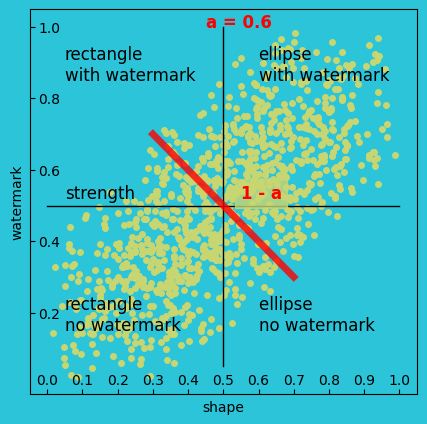

In [2]:
# With this logic the images are distributed
BIAS = 0.6
STRENGTH = 0.5

MODEL_ZOO_INFOS_PATH = "outputs/conv_ground_truth.json"  #noise_pos_accuracies

dataset = BiasedNoisyDataset(bias=BIAS, strength=STRENGTH, verbose=True)

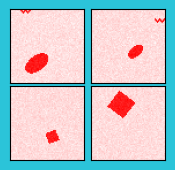

In [4]:
# randomly choose some images to plot
images = torch.zeros(2, 2, 64, 64)
images[0, 0] = dataset[413950][0]
images[0, 1] = dataset[312020][0]
images[1, 0] = dataset[12955][0]
images[1, 1] = dataset[200000][0]

my_plot_grid(images, 2, 2)

# 3. Train Models
- sample the dataset with spurious-to-core feature ratio *a* at intervalls 
- *0.1* steps from 0 to 0.5 and *0.01* steps from 0.5 to 1.0
- for each *a* train 4 models

In [5]:
model = ShapeConvolutionalNeuralNetwork()
[x for x in model.modules()]

[ShapeConvolutionalNeuralNetwork(
   (convolutional_layers): Sequential(
     (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): ReLU()
     (3): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): ReLU()
     (6): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1))
     (7): ReLU()
   )
   (linear_layers): Sequential(
     (0): Linear(in_features=392, out_features=6, bias=True)
     (1): ReLU()
     (2): Linear(in_features=6, out_features=2, bias=True)
   )
 ),
 Sequential(
   (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
   (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (2): ReLU()
   (3): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): ReLU()
   (6): Conv2d(8, 8, kernel_

# 4. Establish Ground-Truth Importance
- use measure similar to Sixt2020 to measure how much the model relies on the core and how much on the spurious feature
- expected: the more biased the dataset is, with which the model is trained, the stronger does the model rely on the watermark
- as long as enough images do not fit the bias, the model is still able to learn the shape

### First of: the accuracies of all models  
*for unbiased data as well as for images "going against" the bias, i.e. rectangles with watermark and ellipses without*

Here it is already quite visible that the accuracy gets worse for the unexpected combinations when *a* increases. 
E.g. a rectangle with watermark will be less recognized the more likely it does not have one in the training dataset

accuracy below 95%: 0


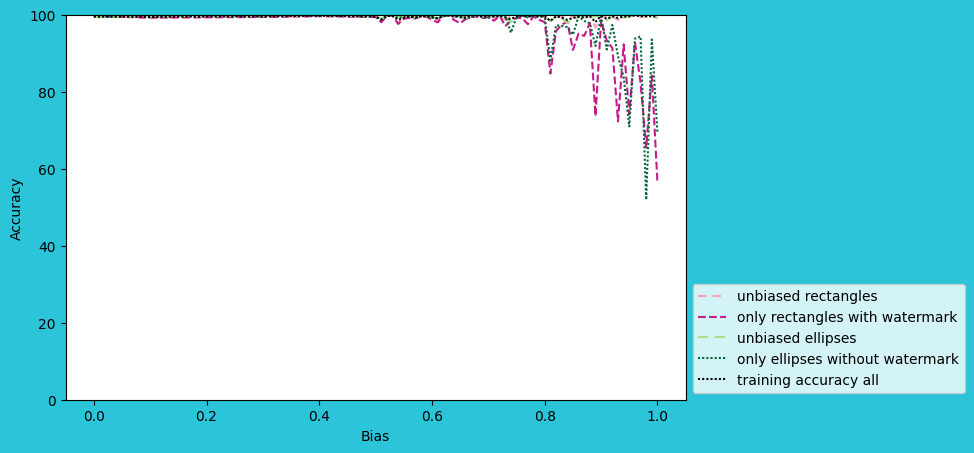

In [3]:
plot_accuracies(MODEL_ZOO_INFOS_PATH, 95)

### Prediction Flip for all models 
*Prediction Flip is computed the following: For a sample set of images the prediction is collected once for the original image. Then the current latent factor (shape, watermark, scale etc.) is changed and the prediction is collected again. The percentage of latent factor changes where the prediction changed is returned and here averaged over the 4 iterations*

- alternatively one can also choose other measures like the correlation coefficient (`ols`) between latent factor value and predicition or the mean logit change (`mean_logit_change`)

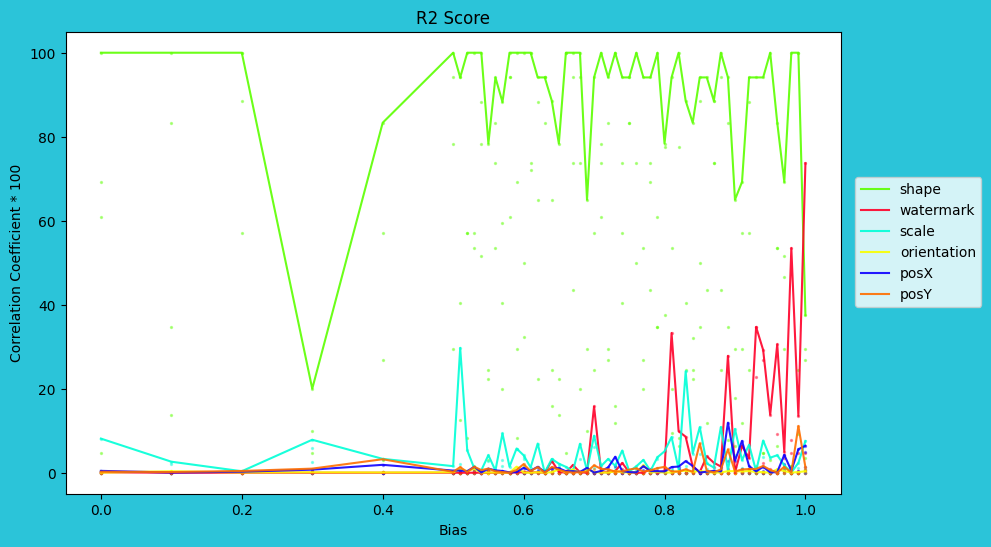

In [12]:
# measure types: ordinary least squares = "ols" , mean logit change = "mean_logit_change", prediction flip: "flip"
plot_pred_flip(MODEL_ZOO_INFOS_PATH, m_type="ols", bcut=0.0)

56 56


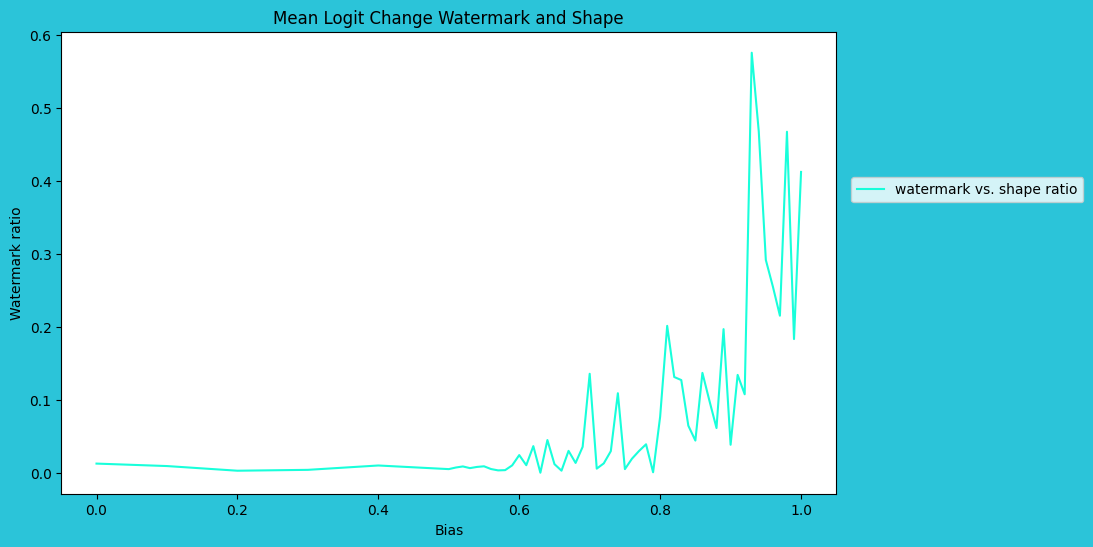

In [34]:
plot_corr_factors(MODEL_ZOO_INFOS_PATH, m_type="mean_logit_change", bcut=0.0)

### Ordinary Least Squares / R2 / Pearson product-moment correlation coefficients for all models
*for each iteration individually and summed over the iterations of each __a__ value. This score computes the correlation coefficient between the given latent factor and the prediction outcome* 

In the image below you see the corr.coef. between the `shape` factor (0 for rectangle, 1 for ellipse) and the values of the 6 neurons in the last linear layer before the output layer called `linear_layers.0`. In other words: How well does the latent factors value determine what the neurons computed relevance is.
The first row shows the measure for each neuron separately, the second row sums the value over all neurons. For comparison the third row shows the same measure applied to the prediction instead of the neurons in a hidden layer and the last shows the generic "ground truth" of the prediction flip.

- Change `factor` to `0` to see how the watermark factor relates to the neurons values
- Change `m_type` to `mean_logit_change` to see the average change of the neurons relevances when changing latent factors instead of R2

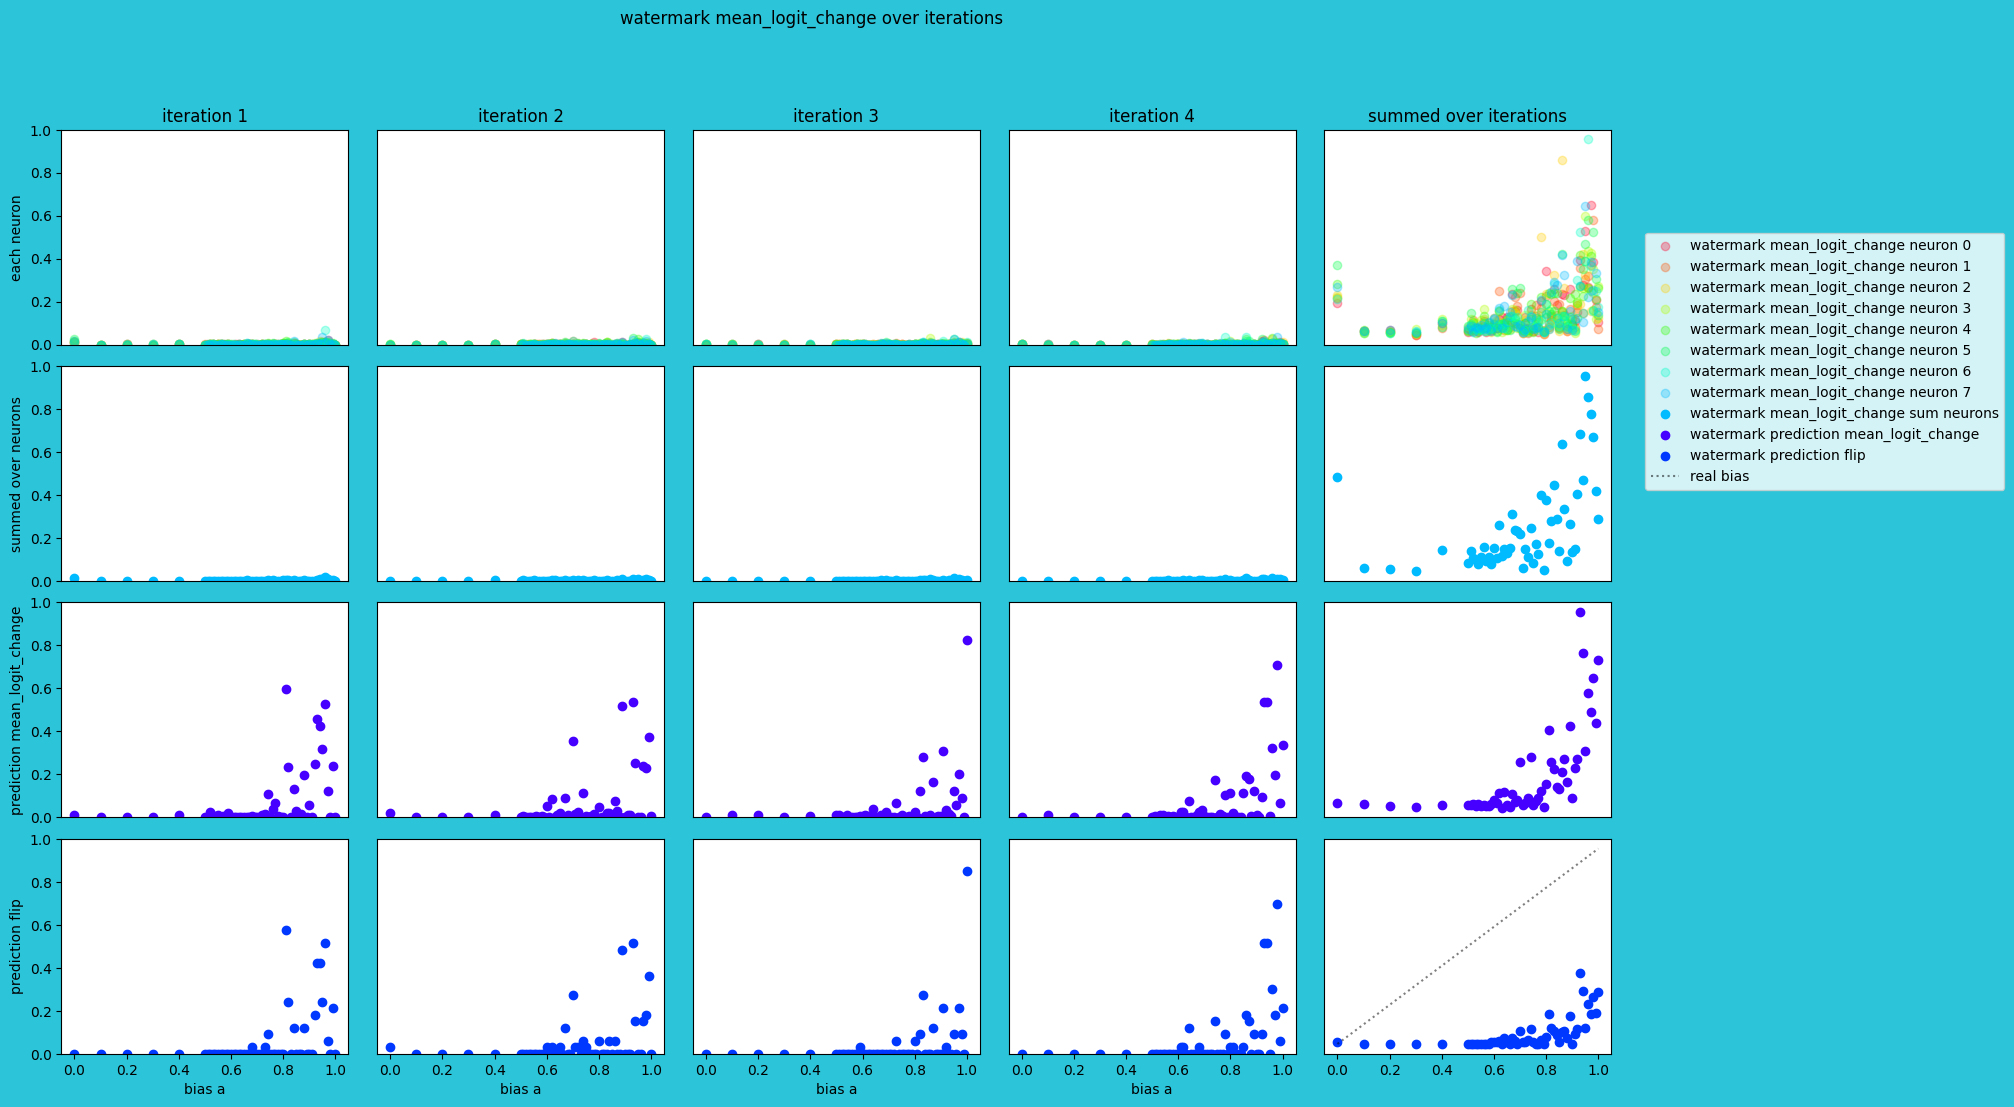

In [5]:
# factors: watermark = 0, shape = 1, scale = 2, orientation = 3, position X = 4, position Y = 5
# measure types: ordinary least squares = "ols" , mean logit change = "mean_logit_change"

ground_truth_plot(MODEL_ZOO_INFOS_PATH, factor=0, m_type="mean_logit_change")

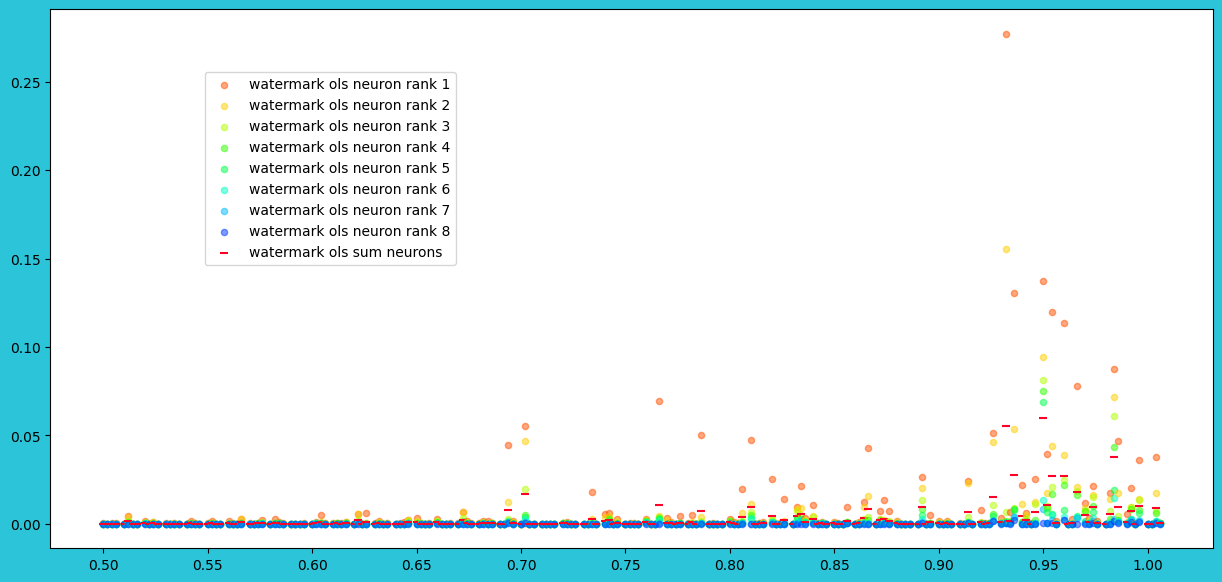

In [7]:
max_neuron_ground_truth_plot(MODEL_ZOO_INFOS_PATH, factor=0, m_type="ols", bcut=0.5)

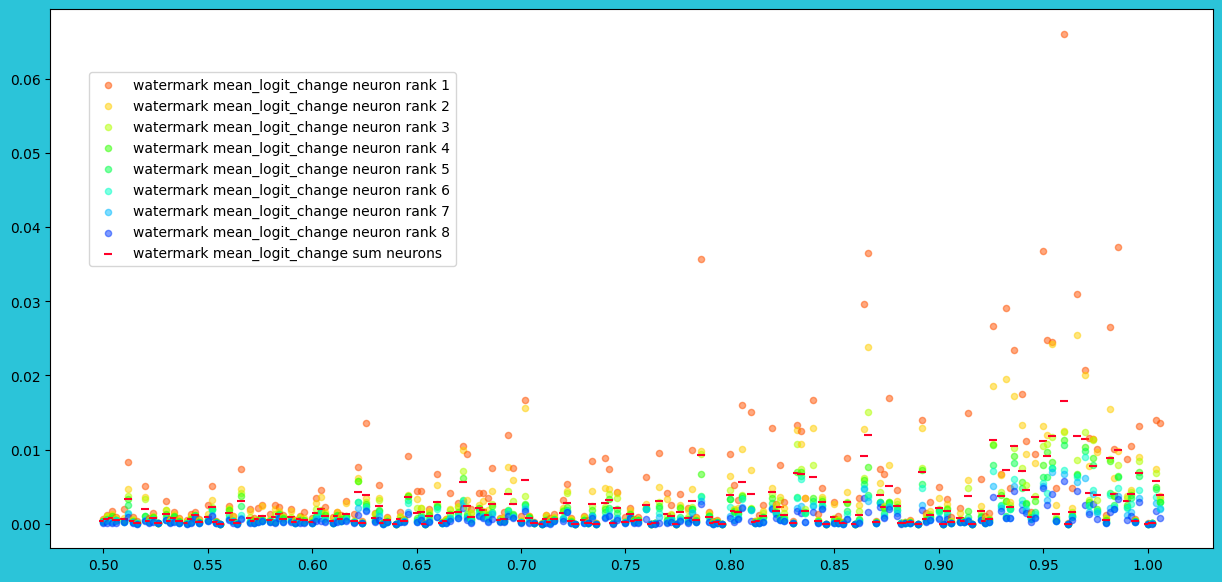

In [8]:
max_neuron_ground_truth_plot(MODEL_ZOO_INFOS_PATH, factor=0, m_type="mean_logit_change", bcut=0.5)

### Mean Logit Change for all models
*Average change of neurons values when latent factor is changed*

This is almost equvalent to the plot above, 

# 5. Compute CRP Attributions

# 6. Find Image Sets With Maximal (CRP-) Relevance

# 7. Disentangle and Identify Concepts

# 8. Evaluate Fidelity of Concept Attribution